# Data-Analysis and Predictions Black-Friday Sales

The goal of this dataset prediction and analysis is to build a model for predict the purchase amount of customers against various products.

Here is 2 dataset that one is for train set and the other is for test set which doesn't have purchase column.

>Dataset columns(features) description:
    <ul>
    <li>User_ID : User id of the customer
    <li>Product_ID: Product id of the product
    <li>Gender: male of female
    <li>Age: Age in bins i.e 0-17, 18-25, 26-35, 36-45, 46-50, 51-55, 55+
    <li>Occupation: Occupation (Masked)
    <li>City_Category: Category of the City (A,B,C)
    <li>Stay_In_Current_City_Years: Number of years stay in current city
    <li>Marital_Status: 0-Unmarried, 1-Married
    <li>Product_Category_1: Product Category (Masked)
    <li>Product_Category_2: Product may belongs to other category also (Masked)
    <li>Product_Category_3: Product may belongs to other category also (Masked)
    <li>Purchase: Purchase Amount (Target Variable)
    </ul>

In [1]:
# import libraries
import numpy as np
import pandas as pd
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
warnings.filterwarnings('ignore')
# libraries for modelling
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

In [2]:
# import train and test set
def import_data(path):
    data = pd.read_csv(path)
    return data

train = import_data('./train.csv')
test = import_data('./test.csv')
print(f'train shape is {train.shape}, test shape is {test.shape}')

train shape is (550068, 12), test shape is (233599, 11)


In [3]:
train.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


In [4]:
# make all column names to lower case for writing easily
train.columns = [i.lower() for i in train.columns]
test.columns = [i.lower() for i in test.columns]
test_copy = test.copy()

In [5]:
# checking for nan values in percentage
train.isnull().mean()*100

user_id                        0.000000
product_id                     0.000000
gender                         0.000000
age                            0.000000
occupation                     0.000000
city_category                  0.000000
stay_in_current_city_years     0.000000
marital_status                 0.000000
product_category_1             0.000000
product_category_2            31.566643
product_category_3            69.672659
purchase                       0.000000
dtype: float64

Column **product_category_3** has **69%** of missing values and we can delete it instead of fill it with median or mean.

Column **product_category_2** later will be filled with median

In [6]:
train.drop('product_category_3', axis=1, inplace=True)

In [7]:
# split numerical columns (categorical columns split later below)
num_data = train.select_dtypes(include=[np.number])
num_data.head(3)

,user_id,occupation,marital_status,product_category_1,product_category_2,purchase
0,1000001,10,0,3,NaN,8370
1,1000001,10,0,1,6.0,15200
2,1000001,10,0,12,NaN,1422


# Exploaratory Data Analysis
This part is for data analysis and visualization of data

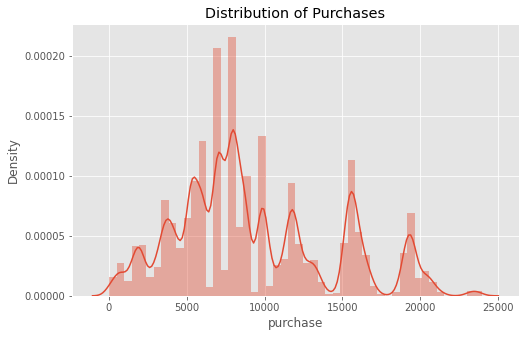

In [8]:
plt.figure(figsize=(8,5))
sns.distplot(train['purchase'])
plt.title('Distribution of Purchases')
plt.show()

In [9]:
def count_plot(x, data, title):
    # creat a function for count plot
    plt.figure(figsize=(8,6))
    sns.countplot(x=x, data=data)
    plt.title(title)
    plt.show()

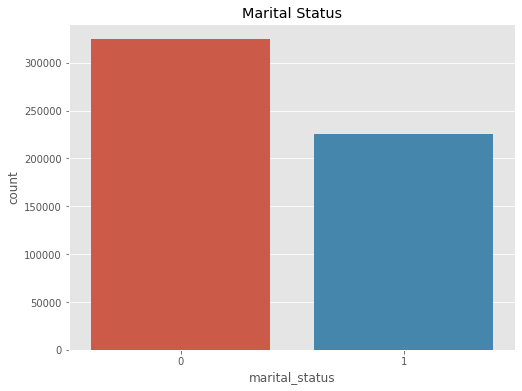

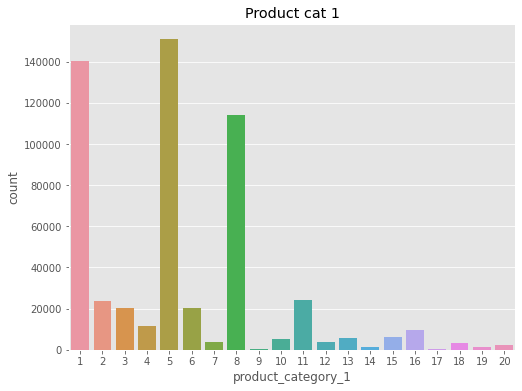

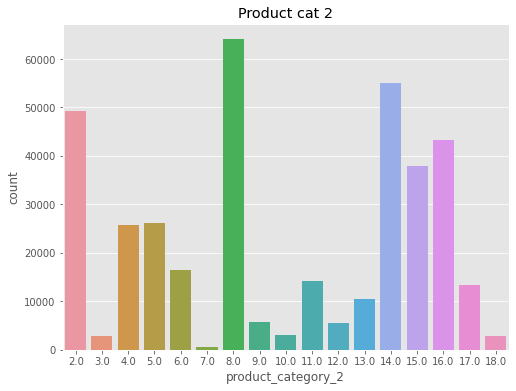

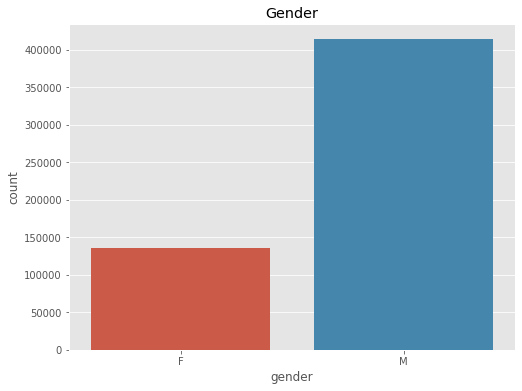

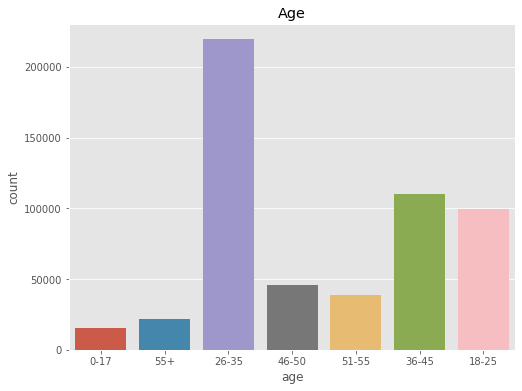

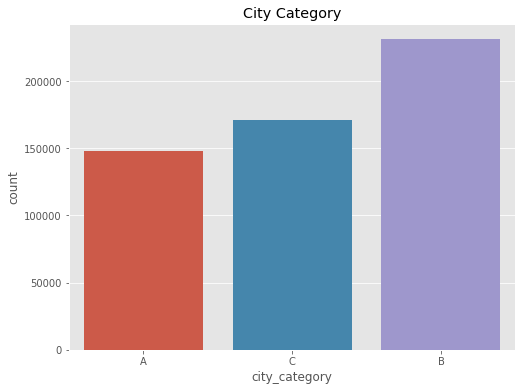

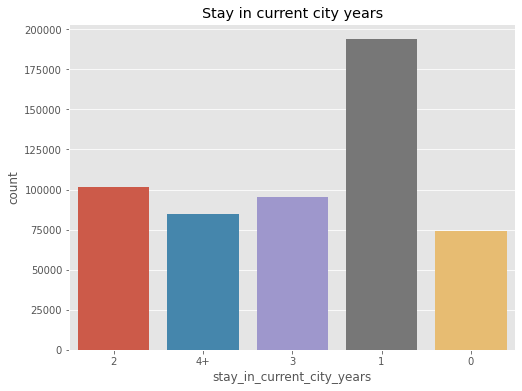

In [10]:
count_plot('marital_status', num_data, 'Marital Status')
count_plot('product_category_1', num_data, 'Product cat 1')
count_plot('product_category_2', num_data, 'Product cat 2')
count_plot('gender', train, 'Gender')
count_plot('age', train, 'Age')
count_plot('city_category', train, 'City Category')
count_plot('stay_in_current_city_years', train, 'Stay in current city years')

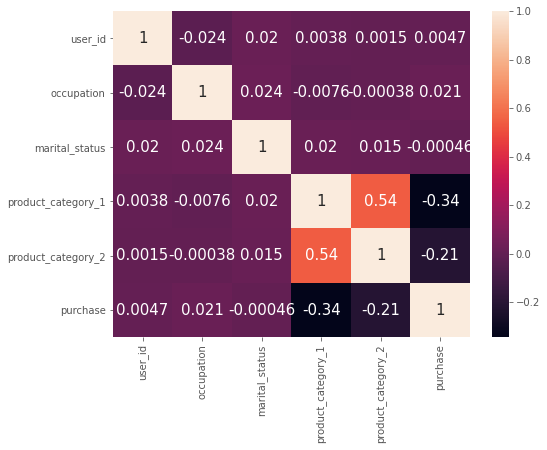

In [11]:
# get correlation of numeric data
corr_matrix = num_data.corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, annot_kws={'size': 15})
plt.show()

**Use barplot for show some feaures relation with purchase (Bivariate Analysis)**

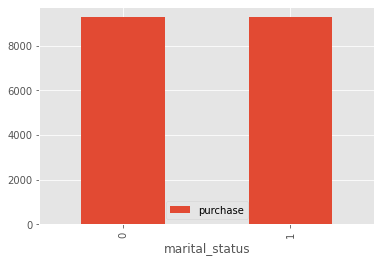

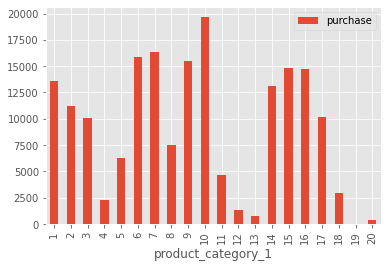

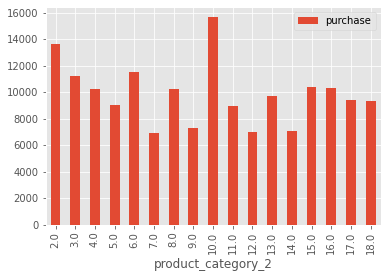

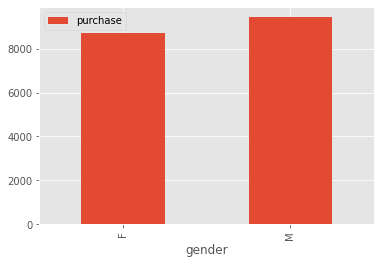

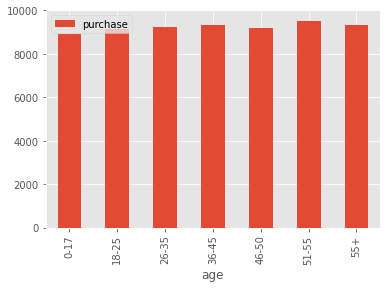

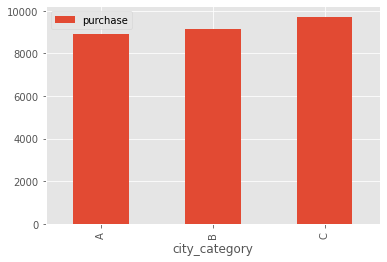

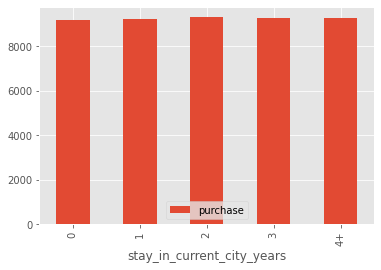

                               purchase
stay_in_current_city_years             
0                           9180.075123
1                           9250.145923
2                           9320.429810
3                           9286.904119
4+                          9275.598872


In [12]:
train.pivot_table(index='marital_status', values='purchase', aggfunc=np.mean).plot(kind='bar')
train.pivot_table(index='product_category_1', values='purchase', aggfunc=np.mean).plot(kind='bar')
train.pivot_table(index='product_category_2', values='purchase', aggfunc=np.mean).plot(kind='bar')
train.pivot_table(index='gender', values='purchase', aggfunc=np.mean).plot(kind='bar')
train.pivot_table(index='age', values='purchase', aggfunc=np.mean).plot(kind='bar')
train.pivot_table(index='city_category', values='purchase', aggfunc=np.mean).plot(kind='bar')
train.pivot_table(index='stay_in_current_city_years', values='purchase', aggfunc=np.mean).plot(kind='bar')
plt.show()
print(train.pivot_table(index='stay_in_current_city_years', values='purchase', aggfunc=np.mean))

# Preprocessing data

In [13]:
# concatenate train and test set together with one more column 'source' which will delete later when splitind data's.
train['source'] = 'train'
test['source'] = 'test'
data = pd.concat([train, test], ignore_index=True, sort=False)

In [14]:
# spliting categorical data
cat_data = data.select_dtypes(include = 'object')
cat_data.drop('source', axis=1, inplace = True)

In [15]:
print(data.shape)
data.drop('product_category_3', axis=1, inplace=True)

(783667, 13)


In [16]:
data.head(3)

,user_id,product_id,gender,age,occupation,city_category,stay_in_current_city_years,marital_status,product_category_1,product_category_2,purchase,source
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,8370.0,train
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,15200.0,train
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,1422.0,train


In [17]:
data.isnull().mean()*100

user_id                        0.000000
product_id                     0.000000
gender                         0.000000
age                            0.000000
occupation                     0.000000
city_category                  0.000000
stay_in_current_city_years     0.000000
marital_status                 0.000000
product_category_1             0.000000
product_category_2            31.388587
purchase                      29.808452
source                         0.000000
dtype: float64

**The nan values for purchase is because of that we don't have purchase column in test set**

In [18]:
data['product_category_2'].fillna(train['product_category_2'].median(), inplace = True)

In [19]:
data.isnull().sum()

user_id                            0
product_id                         0
gender                             0
age                                0
occupation                         0
city_category                      0
stay_in_current_city_years         0
marital_status                     0
product_category_1                 0
product_category_2                 0
purchase                      233599
source                             0
dtype: int64

In [20]:
# Removing Product_Category_1 group 19 and 20 from Train as this is not in Product_Category_2
# Get index of all columns with product_category_1 equal 19 or 20 from train
ind = data.index[(data['product_category_1'].isin([19,29])) & (data['source'] == 'train')]
data.drop(ind, inplace = True)
data.shape

(782064, 12)

# Feature engineering

#### Encode categorical columns 

In [21]:
#from sklearn.preprocessing import LabelEncoder
#le = LabelEncoder()

gender_dict = {'F':0, 'M':1}
data["gender"] = data["gender"].apply(lambda x: gender_dict[x])
print(data["gender"].value_counts())
print('-'*30)
age_dict={'0-17':0, '18-25':1, '26-35':2, '36-45':3, '46-50':4, '51-55':5, '55+':6}
data['age']=data['age'].apply(lambda x:age_dict[x])
print(data['age'].value_counts())
print('-'*30)
city={'A':0,'B':1,'C':2}
data['city_category']=data['city_category'].apply(lambda x: city[x])
print(data['city_category'].value_counts())
print('-'*30)
def stay(Stay_In_Current_City_Years):
        if Stay_In_Current_City_Years == '4+':
            return 4
        else:
            return Stay_In_Current_City_Years
data['stay_in_current_city_years'] = data['stay_in_current_city_years'].apply(stay).astype(int)

1    588879
0    193185
Name: gender, dtype: int64
------------------------------
2    312452
3    156404
1    141678
4     65129
5     54650
6     30476
0     21275
Name: age, dtype: int64
------------------------------
1    329277
2    242816
0    209971
Name: city_category, dtype: int64
------------------------------


#### Exporting  clean data

In [22]:
#Divide into test and train:
#train = df.loc[df['source']=="train"]
#test = df.loc[df['source']=="test"]

#Drop unnecessary columns:
#test.drop(['source'],axis=1,inplace=True)
#train.drop(['source'],axis=1,inplace=True)

#Export files as modified versions:
#train.to_csv("train_clean.csv",index=False)
#test.to_csv("test_clean.csv",index=False)

#train= pd.read_csv('train_clean.csv')
#test= pd.read_csv('test_clean.csv')

# Modelling

we want to do 3 models for dataset:
- Random Forest regression
- Linear regression
- Decision Tree regression

In [23]:
# spliting train and test set for modelling from 'data'
train = data.loc[data['source'] == 'train']
test = data.loc[data['source'] == 'test']
test.drop(['source'],axis=1,inplace=True)
train.drop(['source'],axis=1,inplace=True)

In [24]:
# make train set to input and output for model
x = train.drop(['product_id', 'user_id', 'purchase'], axis=1)
y = train['purchase']

In [25]:
# split train set in 'train and test set' in phase training
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state = 42)

In [26]:
# linear regression
lin_reg = LinearRegression()
# decision tree
tree_reg = DecisionTreeRegressor()
# random forest
forest_reg = RandomForestRegressor(random_state=42)

In [27]:
def modelling(model, x, y, x_test, y_test):
    # modelling function for fit and predict on different models and return score errors
    model.fit(x,y)
    y_pred = model.predict(x_test)
    r2 = r2_score(y_test, y_pred)
    mse = np.sqrt(mean_squared_error(y_test, y_pred))
    return r2, mse

In [28]:
r2_reg, mse_reg = modelling(lin_reg, x_train, y_train, x_test, y_test)
r2_tree, mse_tree = modelling(tree_reg, x_train, y_train, x_test, y_test)
r2_forest, mse_forest = modelling(forest_reg, x_train, y_train, x_test, y_test)

In [29]:
# make a dataframe that compare 3 models scores
compare_dict = {'R2':[r2_reg, r2_tree, r2_forest],
       'MSE':[mse_reg, mse_tree, mse_forest]}
compare = pd.DataFrame(compare_dict, index=['LinearRegression', 'DecisionTree', 'RandomForest'])
compare

,R2,MSE
LinearRegression,0.116024,4704.422179
DecisionTree,0.604090,3148.360580
RandomForest,0.637201,3013.833348


## Tune model

In [30]:
#this may take some time
# grid =  {"n_estimators": [10, 100],
#          "max_depth": [None,50],
#          "max_features": ["auto", "sqrt"],
#          "min_samples_leaf": [2,10],
#          "min_samples_split": [2,5]}
# from sklearn.model_selection import GridSearchCV
# tune_model = GridSearchCV(forest_reg, param_grid=grid, n_jobs=-1, cv=5)
# tune_model.fit(x_train, y_train)

After this step we find the best parameters with **tune_model.best_params_**
and we **fit** the **random forest with best params** and make predictions again.

# Predict on test set

In [32]:
test = test.drop(['user_id', 'product_id', 'purchase'], axis=1)
test_pred = forest_reg.predict(test)

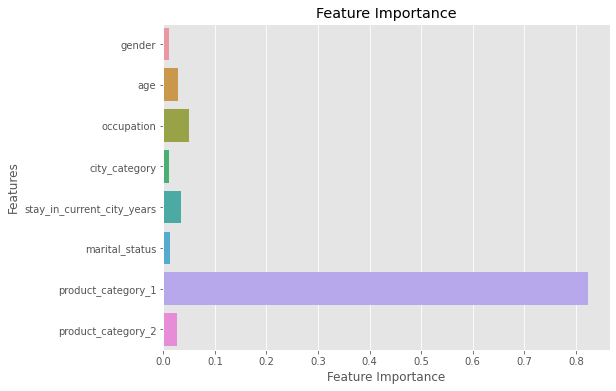

In [33]:
# create a dataframe for show each feature and feature importance
feature_imp_df = pd.DataFrame({'Features': test.columns,
                               'Feature Importance': forest_reg.feature_importances_},)
feature_imp_df.sort_values(['Feature Importance'],ascending=False).reset_index(drop=True)

# plot feature importance 
plt.figure(figsize=(8,6))
plt.title('Feature Importance')
sns.barplot(x='Feature Importance', y='Features', data=feature_imp_df)
plt.show()

In [34]:
# a tabel for show predictions for 'user_id & product_id'
predict_category = test_copy[['user_id', 'product_id']]
predict_category['predicted_purchase'] = test_pred
predict_category.head()

,user_id,product_id,predicted_purchase
0,1000004,P00128942,18181.936488
1,1000009,P00113442,10561.240286
2,1000010,P00288442,8096.531401
3,1000010,P00145342,2457.780000
4,1000011,P00053842,1955.146238


In [35]:
# save predicted values
#predict_category.to_csv('predicted.csv', index=False)